### Compound chemical feature prediction 

This tutorial explores a dataset that contains LogP values and compound structure information.

We will first explore the data and generate additional descriptors. This will help us to better capture the chemical space features. In addition, we will also encode each compound using a RDkit fingerprint. Following this we will assess if LogP can be predicted using different ML methods, such as Gradient Boosting Regression and AdaBoost Regressor. We will aim to model LogP based on physicochemical and structural features. 

As an additional analytical point, we will explore how we can select certain physicochemical features more effectively. Such analyses typically help assess the most relevant parameters.

Please note this is a high-level example to demonstrate some of the modelling capabilities and basic EDA. For a more streamlined approach, you would usually need to package your analyses into modules or classes to increase reusability and reproducibility. Moreover, you would also need to include various different analytical approaches, such as diverse fingerprint testing, compound characteristics analyses, base models, etc.

In [70]:
#Import libraries
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem,PandasTools, Descriptors, Draw

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score


In [71]:
#Helper functions

def modelling_summary(model,y_test,y_pred,p):
    """
    Function takes model, features, test and predicted data to generate summaries.
    #Arguments
        model, model obj - fitted model
        y_test, list/array - test data 
        y_pred, list/array - predicted data
        p, int - predictor paramater number 
    #Returns
        MSE, MEA, R2 score, R2 adjusted
    """
    if len(y_test)!=len(y_pred):
        raise ValueError('Test and predicted datasets do not match')
    if not isinstance(p,int):
        raise ValueError('Parameter number is not an integer')    
    
    R2=r2_score(y_test,y_pred)
    n=len(y_test)
    if n>p:
        R2_adj=1-(1-R2)*(n-1)/(n-p-1)
    else:
        R2_adj=None
    print ('MSE',mean_squared_error(y_test,y_pred),'\n')
    print ('MAE',mean_absolute_error(y_test,y_pred),'\n')
    print ('R2',R2,'\n')
    if R2_adj is not None:
        print ('R2 adjusted',R2_adj,'\n')
    return

def reg_plot(y_test,y_pred):
    """
    Function plots a distribution between test and predicted datasets.
    #Arguments

        y_test, list/array - test data 
        y_pred, list/array - predicted data

    #Returns
        Regression plot and R2 value
    """
    if len(y_test)!=len(y_pred):
        raise ValueError('Test and predicted datasets do not match')

    R2=r2_score(y_test,y_pred)

    sns.regplot(x=y_test,y=y_pred,scatter_kws={'alpha':0.25})
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title(f"R2 {R2}")
    plt.show()
    return


In [72]:
#Import data

#We are going to use CHEMBL small molecule phase 3 and 4 data

data=pd.read_table("./Data/LogP_data.csv",sep=',')
data.columns=['ID','LogP','ESOL','SMILES']
data.head()

,ID,LogP,ESOL,SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [73]:
#Prepare data
PandasTools.AddMoleculeColumnToFrame(data,smilesCol='SMILES',molCol='RMol')

#Add hidrogens to MOL for future analyses
data['RMolH']=data.RMol.apply(lambda x: Chem.AddHs(x))
#Add molecular descriptors

data["MW"]=data.RMolH.apply(lambda x: Descriptors.ExactMolWt(x))
data["TPSA"]=data.RMolH.apply(lambda x: Chem.rdMolDescriptors.CalcTPSA(x))
data["AromaticRings"]=data.RMolH.apply(lambda x: Chem.rdMolDescriptors.CalcNumAromaticRings(x))
data["nRB"]=data.RMolH.apply(lambda x: Descriptors.NumRotatableBonds(x))
data["HBA"]=data.RMolH.apply(lambda x: Descriptors.NumHAcceptors(x))
data["HBD"]=data.RMolH.apply(lambda x: Descriptors.NumHDonors(x))
data["LogP"]=data.RMolH.apply(lambda x: Descriptors.MolLogP(x))

In [23]:
data.head()

,ID,LogP,ESOL,SMILES,RMol,RMolH,MW,TPSA,AromaticRings,nRB,HBA,HBD
0,"1,1,1,2-Tetrachloroethane",2.5954,-2.794,ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x000002046AA...,<rdkit.Chem.rdchem.Mol object at 0x00000204709...,165.891061,0.0,0,0,0,0
1,"1,1,1-Trichloroethane",2.3765,-2.232,CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x00000204709...,<rdkit.Chem.rdchem.Mol object at 0x00000204709...,131.930033,0.0,0,0,0,0
2,"1,1,2,2-Tetrachloroethane",2.5938,-2.549,ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x00000204709...,<rdkit.Chem.rdchem.Mol object at 0x00000204709...,165.891061,0.0,0,1,0,0
3,"1,1,2-Trichloroethane",2.0289,-1.961,ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x00000204709...,<rdkit.Chem.rdchem.Mol object at 0x00000204709...,131.930033,0.0,0,1,0,0
4,"1,1,2-Trichlorotrifluoroethane",2.9189,-3.077,FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x00000204709...,<rdkit.Chem.rdchem.Mol object at 0x00000204709...,185.901768,0.0,0,1,0,0


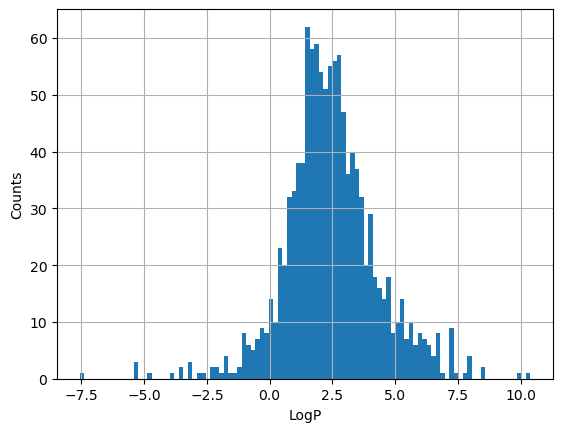

In [96]:
#Explore data

data.LogP.hist(bins=100)
plt.xlabel('LogP')
plt.ylabel('Counts')
plt.show()


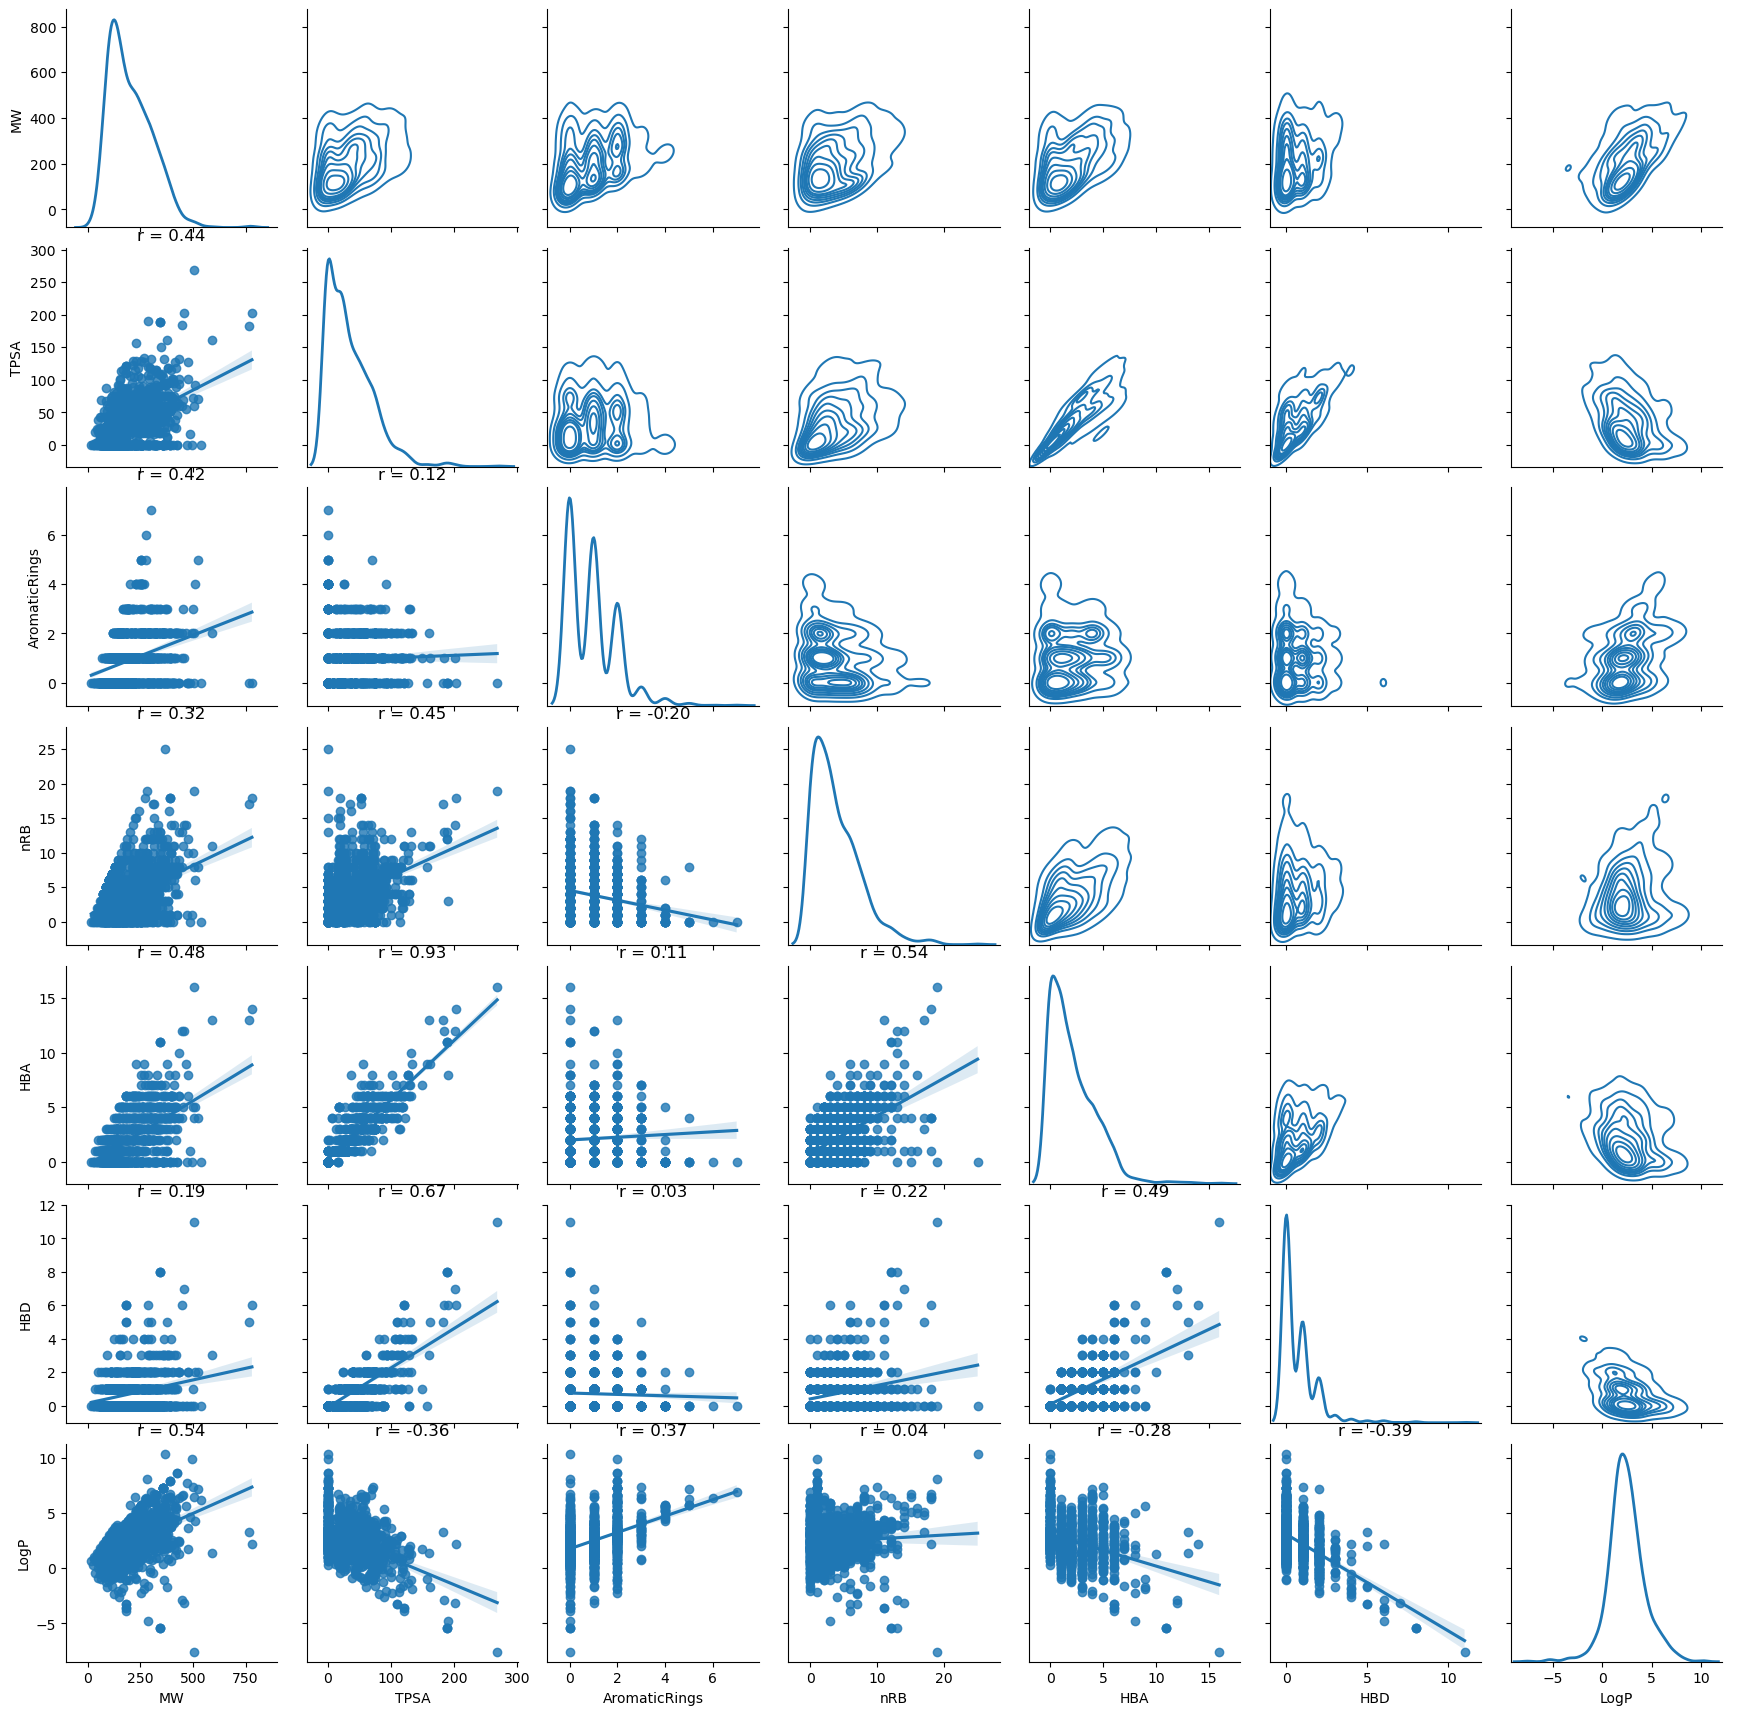

In [97]:
from scipy.stats import spearmanr
def corr(x,y,**kwargs):
    
    r,p=spearmanr(x,y)
    plt.title(f'r = {r:.2f}')
    
    return

p = sns.PairGrid(data[['MW', 'TPSA', 'AromaticRings',  'nRB', 'HBA', 'HBD', 'LogP']], palette=['blue','red','green','orange','grey','lightblue'], diag_sharey=False)
p.map_lower(sns.regplot)
p.map_upper(sns.kdeplot)
p.map_diag(sns.kdeplot, lw=2)
p.map_lower(corr)
p.add_legend()
plt.show()

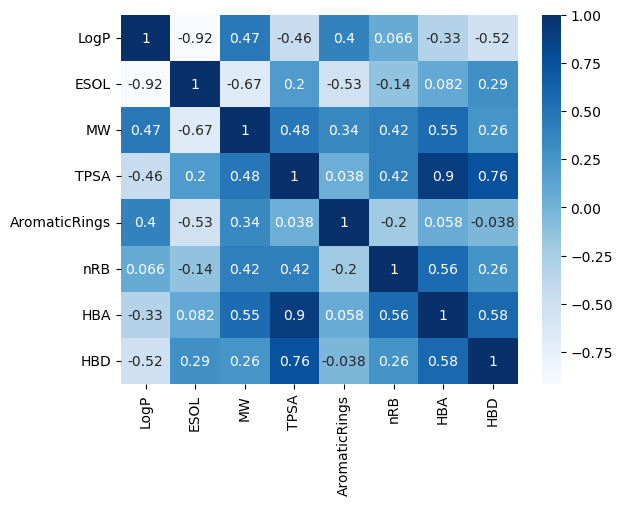

In [99]:
sns.heatmap(data.corr(),annot=True,cmap='Blues',fmt='.2g')
plt.show()

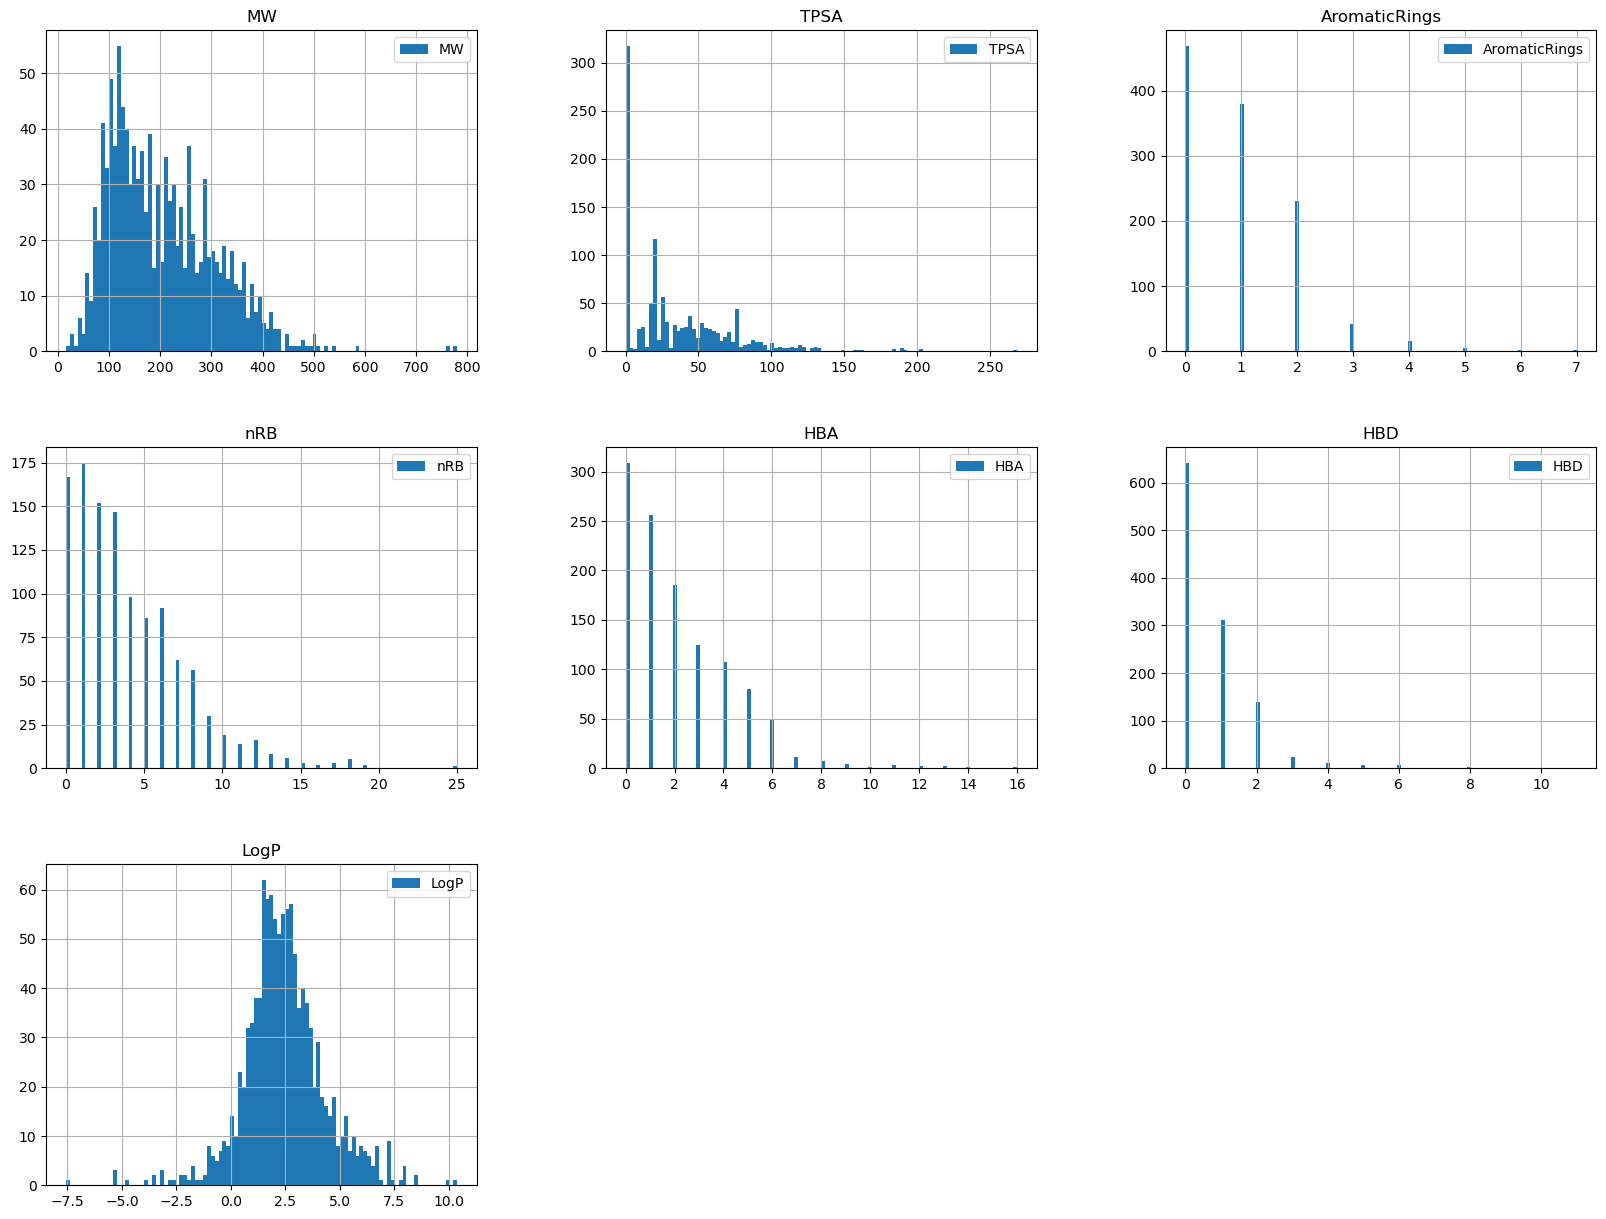

In [100]:

#In addition you can explore individual distributions to better understand how data points are distributed and capture potential outliers
data[['MW', 'TPSA', 'AromaticRings',  'nRB', 'HBA', 'HBD', 'LogP']].hist(bins=100,figsize=(20, 15), legend=True)
plt.show()


In [113]:
#Prepare data for training using compound parameters
#We are going to focus on physicochemical features to predict bioactivities
features=['MW', 'TPSA', 'AromaticRings',  'nRB', 'HBA', 'HBD']
X=data[features]
y=data['LogP']


X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.2,random_state=0)
#Define indexes
train_idx=X_train.index.to_list()
test_idx=X_test.index.to_list()
#Scale data
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)


In [114]:
#Fingerprint based classification

#Add fingerprint infomration
data['MorganFP']=data.RMol.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x,radius=2,nBits=1024)) #H is not important for a similarity structure search
X_fp=data['MorganFP']
#Convert into array
X_fp=[list(i) for i in X_fp]

X_train_fp=np.array(X_fp)[train_idx]

X_test_fp=np.array(X_fp)[test_idx]

[(0.41200244287497517, 'MW'), (0.3669899683018226, 'TPSA'), (0.0003271803582726051, 'AromaticRings'), (0.05341614047239885, 'nRB'), (0.11706274344945403, 'HBA'), (0.05020152454307655, 'HBD')]
MSE 1.1028126315966134 

MAE 0.7254608579460265 

R2 0.678897372157829 



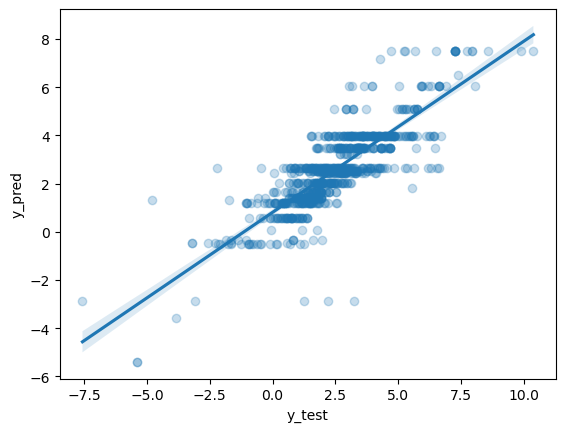

In [20]:
#Before modelling let's explore what features might be the most important

#Decision trees are extremely useful as they provide an interpretable method to
#capture important features

model=DecisionTreeRegressor(max_depth=5,criterion='squared_error')
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

print(list(zip(model.feature_importances_,features)))
print ('MSE',mean_squared_error(y_test,y_pred),'\n')
print ('MAE',mean_absolute_error(y_test,y_pred),'\n')
print ('R2',r2_score(y_test,y_pred),'\n')

sns.regplot(x=y_test,y=y_pred,scatter_kws={'alpha':0.25})
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

In [21]:
#There are various methods to select and assess a relative feature importance
#One simple approach is to use SelectKBest

#Perform SelectKBest analysis

selection=SelectKBest(k=5,score_func=f_regression)
selection.fit(X_train,y_train)

print(list(zip(selection.scores_,np.round(selection.pvalues_,3),features)))

[(68.77777124695804, 0.0, 'MW'), (64.42196676745115, 0.0, 'TPSA'), (48.21457326448744, 0.0, 'AromaticRings'), (0.03115755176195351, 0.86, 'nRB'), (31.342673624794088, 0.0, 'HBA'), (94.77357412020147, 0.0, 'HBD')]


Decision trees used squared error to capture the most relevant features, while SelectKBest relied on F-statistic. We can see that both appraches put a high importance on MW and TPSA.

For the analysis we will use all parameters; however, some further fine tuning is always required when preparing an actual model to select the best parameters that offer the most stability and the best generalisation.

MSE 0.5063231848943498 

MAE 0.48394928662325415 

R2 0.8525754053328052 

R2 adjusted 0.8516023056980382 



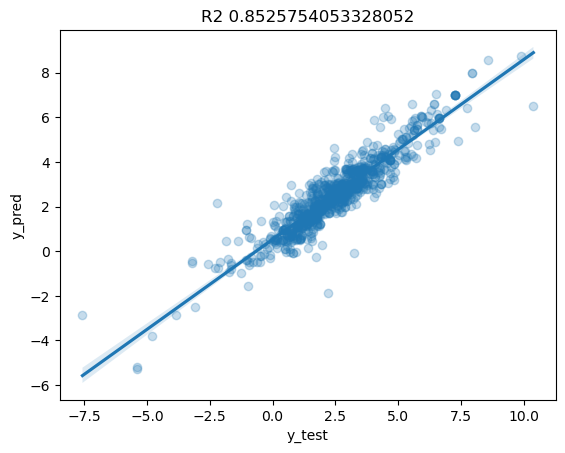

In [38]:
#Perform GradientBoosting modelling
model=GradientBoostingRegressor()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

#Assess model performance
modelling_summary(model,y_test,y_pred,len(features))
reg_plot(y_test,y_pred)

MSE 0.5201753552329076 

MAE 0.4872688620797012 

R2 0.8485421106736856 

R2 adjusted 0.8480438939324806 



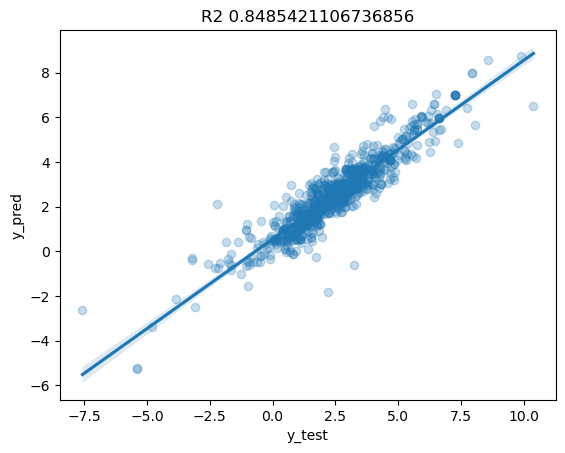

In [39]:
#Perform GradientBoosting analysis on PCA dimentionality reduced data set
pca=PCA(n_components=3)
X_train_PCA=pca.fit_transform(X_train)
X_test_PCA=pca.transform(X_test)

model=GradientBoostingRegressor()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

#Assess model performance
modelling_summary(model,y_test,y_pred,3)
reg_plot(y_test,y_pred)

MSE 0.7839556145986163 

MAE 0.6372951824404606 

R2 0.771738008119481 

R2 adjusted 0.7702313283050881 



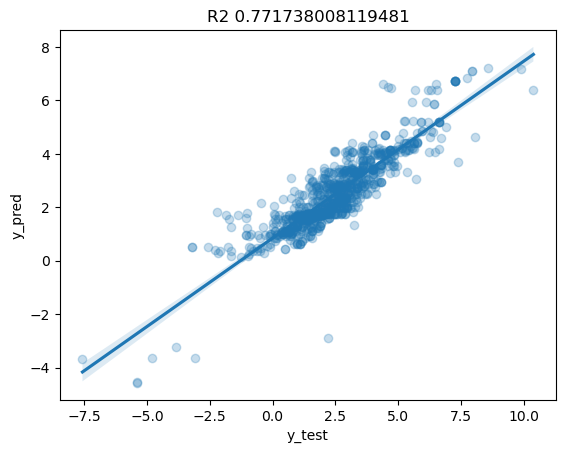

In [40]:
#Perform AdaBoost modelling
model=AdaBoostRegressor(n_estimators=100,loss='exponential',learning_rate=1)
model.fit(X_train,y_train)

y_pred=model.predict(X_test)
#Assess model performance
modelling_summary(model,y_test,y_pred,len(features))
reg_plot(y_test,y_pred)

MSE 0.7839556145986163 

MAE 0.6372951824404606 

R2 0.771738008119481 

R2 adjusted 0.7709871463040846 



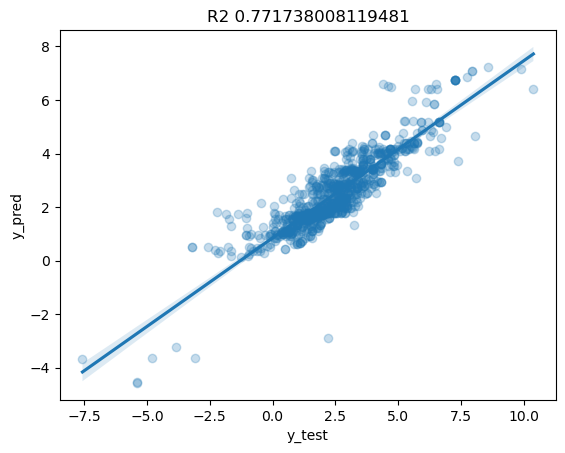

In [41]:
#Perform AdaBoost analysis on PCA dimentionality reduced data set
pca=PCA(n_components=3)
X_train_PCA=pca.fit_transform(X_train)
X_test_PCA=pca.transform(X_test)

model=AdaBoostRegressor(n_estimators=100,loss='exponential',learning_rate=1)
model.fit(X_train,y_train)


#Assess model performance
modelling_summary(model,y_test,y_pred,3)
reg_plot(y_test,y_pred)

### Fingerprint derived structural feature analysis

MSE 1.392389613514291 

MAE 0.8452139983547587 

R2 0.5945821157014786 



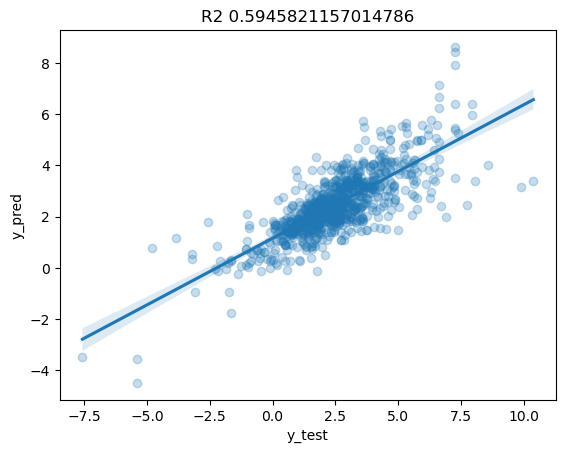

In [47]:
#Perform GradientBoosting modelling
model=GradientBoostingRegressor()
model.fit(X_train_fp,y_train)

y_pred=model.predict(X_test_fp)

#Assess model performance
modelling_summary(model,y_test,y_pred,1024)
reg_plot(y_test,y_pred)

MSE 3.371466531093449 

MAE 1.3333676198194624 

R2 0.018340258536298948 

R2 adjusted 0.01511111464990511 



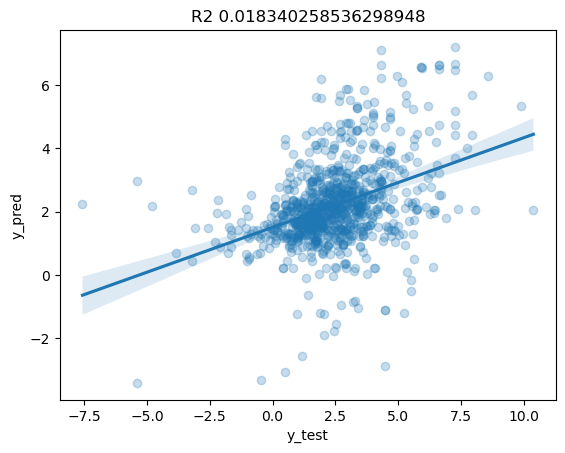

In [48]:
#Perform GradientBoosting analysis on PCA dimentionality reduced data set
pca=PCA(n_components=3)
X_train_PCA=pca.fit_transform(X_train_fp)
X_test_PCA=pca.transform(X_test_fp)

model=GradientBoostingRegressor()
model.fit(X_train_PCA,y_train)

y_pred=model.predict(X_test_PCA)

#Assess model performance
modelling_summary(model,y_test,y_pred,3)
reg_plot(y_test,y_pred)

MSE 1.86915123096905 

MAE 1.0628368637031993 

R2 0.4557648734675285 



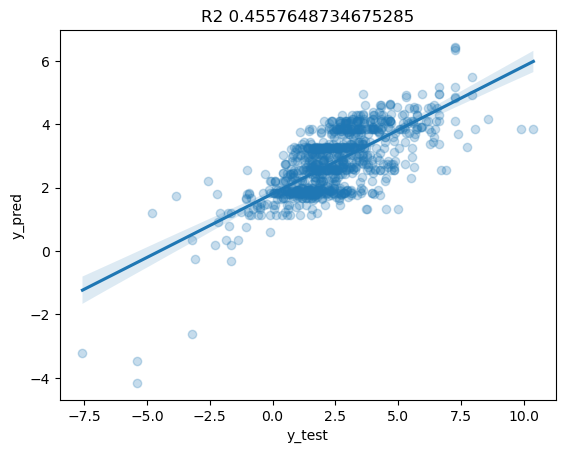

In [49]:
#Perform AdaBoost modelling
model=AdaBoostRegressor(n_estimators=100,loss='exponential',learning_rate=1)
model.fit(X_train_fp,y_train)

y_pred=model.predict(X_test_fp)
#Assess model performance
modelling_summary(model,y_test,y_pred,1024)
reg_plot(y_test,y_pred)

MSE 1.86915123096905 

MAE 1.0628368637031993 

R2 0.4557648734675285 

R2 adjusted 0.4539746263407769 



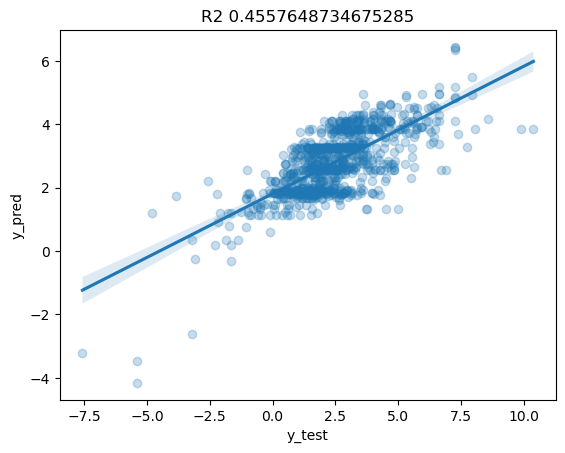

In [51]:
#Perform AdaBoost analysis on PCA dimentionality reduced data set
pca=PCA(n_components=3)
X_train_PCA=pca.fit_transform(X_train)
X_test_PCA=pca.transform(X_test)

model=AdaBoostRegressor(n_estimators=100,loss='exponential',learning_rate=1)
model.fit(X_train,y_train)


#Assess model performance
modelling_summary(model,y_test,y_pred,3)
reg_plot(y_test,y_pred)

### Combining physicochemical and structural feature analysis

In [115]:
X_train=data.loc[train_idx,features]
fp_df_train=pd.DataFrame(X_train_fp,index=train_idx,columns=[f'FP_{i}' for i in range(1024)])
X_train=pd.concat([X_train,fp_df_train],axis=1)
X_test=data.loc[test_idx,features]
fp_df_test=pd.DataFrame(X_test_fp,index=test_idx,columns=[f'FP_{i}' for i in range(1024)])
X_test=pd.concat([X_test,fp_df_test],axis=1)


MSE 0.480626584897742 

MAE 0.4693234639799791 

R2 0.8600574068524777 

R2 adjusted 0.8591336933663554 



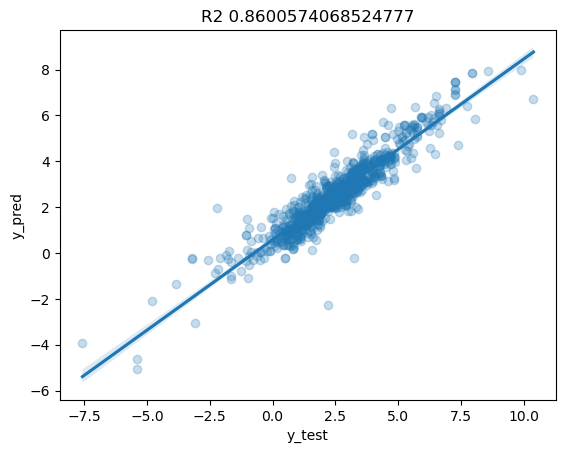

In [117]:
#Perform GradientBoosting modelling
model=GradientBoostingRegressor()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

#Assess model performance
modelling_summary(model,y_test,y_pred,len(features))
reg_plot(y_test,y_pred)

MSE 0.8077184392160434 

MAE 0.6463559375296929 

R2 0.7648190581446683 

R2 adjusted 0.763266708693478 



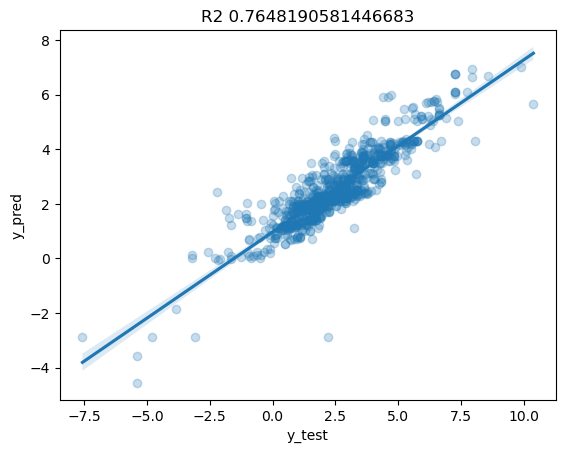

In [118]:
#Perform AdaBoost modelling
model=AdaBoostRegressor(n_estimators=100,loss='exponential',learning_rate=1)
model.fit(X_train,y_train)

y_pred=model.predict(X_test)
#Assess model performance
modelling_summary(model,y_test,y_pred,len(features))
reg_plot(y_test,y_pred)